In [1]:
from scipy.integrate import odeint
import math 
import numpy as np
import astroabc
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

%matplotlib inline


In [11]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param

    #define states
    X,Y,Z=y


    #define derivatives
    dX_dt = a*(Y-X)
    dY_dt = X*(b-Z)-Y
    dZ_dt = X*Y -c*Z
    
    return dX_dt,dY_dt,dZ_dt
    
def model_sol(param):
    
    y0 = [1.,1.,1.]
    time = np.linspace(0, 100, 1000)

    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

array([[ 7.26437805, -3.24197867, 35.79321362]])

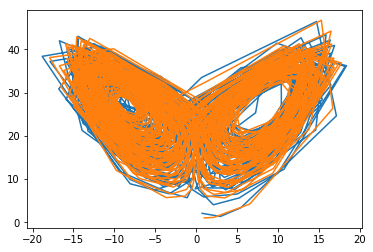

In [12]:
time = np.linspace(0, 100, 1000)
sol=model_sol([10.,28.,8./3.])
Y=np.ones((len(time),3))
for states in range(3):
    Y[:,states] = sol[:,states] + np.random.randn(len(time),)*(0.1*np.std(sol[:,states]))

plt.plot(Y[:,0],Y[:,2])
plt.plot(sol[:,0],sol[:,2])
sol[-1:,:]

In [13]:
kernX = GPy.kern.Matern32(1) #+ GPy.kern.Bias(1)
kernY = GPy.kern.Matern32(1) 
kernZ = GPy.kern.Matern32(1) + GPy.kern.Bias(1)
input_time=time[-200:].reshape(200,1)
modelX = GPy.models.GPRegression(input_time, Y[-200:,0].reshape(len(input_time),1), kernX)
modelY = GPy.models.GPRegression(input_time, Y[-200:,1].reshape(len(input_time),1), kernY)
modelZ = GPy.models.GPRegression(input_time, Y[-200:,2].reshape(len(input_time),1), kernZ)
modelZ.Gaussian_noise.variance=0.23

In [14]:
modelX.optimize_restarts(optimizer='lbfgs',messages=True,num_restarts = 1)
modelY.optimize_restarts(optimizer='lbfgs',messages=True,num_restarts = 1)
modelZ.optimize_restarts(optimizer='scg',messages=True,num_restarts = 1)

Optimization restart 1/1, f = 530.042633783
Optimization restart 1/1, f = 598.204218041
Optimization restart 1/1, f = 623.976759873


In [15]:
sampler=GPy.inference.mcmc.hmc.HMC(modelZ)
Sam=sampler.sample()
modelZ.Gaussian_noise.variance=np.mean(Sam[:,2])
modelZ.kern.variance=np.mean(Sam[:,0])
modelZ.kern.lengthscale=np.mean(Sam[:,1])

KeyboardInterrupt: 

 /usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


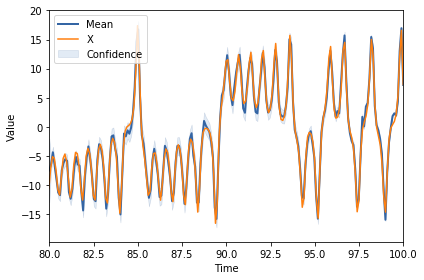

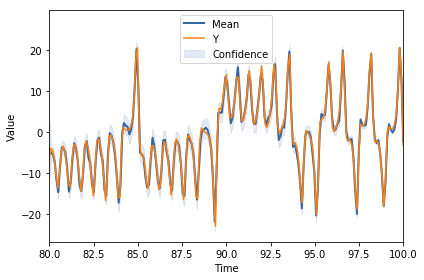

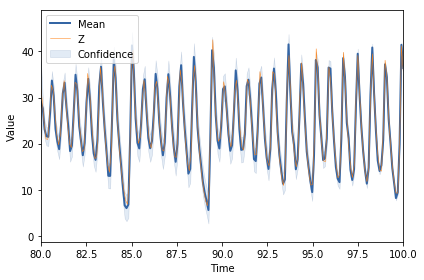

In [16]:
modelX.plot_noiseless([80,100])
plt.plot(time,sol[:,0],color='#ff7f0e',lw=1.5,label='X')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
modelY.plot_noiseless([80,100])
plt.plot(time,sol[:,1],color='#ff7f0e',lw=1.5,label='Y')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
modelZ.plot_noiseless([80,100])
plt.plot(time,sol[:,2],color='#ff7f0e',lw=0.5,label='Z')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

In [17]:
#modelX.optimize(optimizer='cg',messages=True)
X_f=modelX.posterior_samples_f(input_time,size=10)
dX_f=modelX.predictive_gradients(input_time)
Y_f=modelY.posterior_samples_f(input_time,size=10)
dY_f=modelY.predictive_gradients(input_time)
Z_f=modelZ.posterior_samples_f(input_time,size=10)
dZ_f=modelZ.predictive_gradients(input_time)
xbar=[X_f,Y_f,Z_f]
dxbar = [dX_f[0].reshape(len(input_time),),dY_f[0].reshape(len(input_time),),dZ_f[0].reshape(len(input_time),)]

 /usr/local/lib/python2.7/dist-packages/GPy/core/gp.py:500: RuntimeWarning:covariance is not positive-semidefinite.


In [ ]:
def simulation_rhs_f(trial):
    stateLen = 200
    sample = 10
    
    xbar_X, xbar_Y, xbar_Z = xbar
    rhsf_X = np.ones((stateLen,sample))
    rhsf_Y = np.ones((stateLen,sample))
    rhsf_Z = np.ones((stateLen,sample))
    for t in range(stateLen):
        for j in range(sample):
            rhsf_X[t,j] = (xbar_Y[t,j] - xbar_X[t,j])*trial[0]
            rhsf_Y[t,j] = xbar_X[t,j]*(trial[1] - xbar_Z[t,j]) - xbar_Y[t,j]
            rhsf_Z[t,j] = xbar_X[t,j]*xbar_Y[t,j] - trial[2]*xbar_Z[t,j]
    
    if np.any(np.array([trial])<0.0):
        rhsf_X[0,:]=-1000.
        rhsf_Y[0,:]=-1000.
        rhsf_Z[0,:]=-1000.
       
        
    return [rhsf_X.mean(axis=1),rhsf_Y.mean(axis=1),rhsf_Z.mean(axis=1)]



In [ ]:
def dist_metric(d,x):
    dist=0.0
    for states in range(3):
        #dist += np.dot((d[states]-x[states]),(d[states]-x[states]).T)
        
        if np.all(np.array(x[states][0]==-1000.0)):
            dist += np.inf
        else:
            dist += np.sum((d[states]-x[states])**2)    
        
    
    return dist
    

In [ ]:
tt=simulation_rhs_f([10,28,8/3])
plt.figure(figsize=(15, 7.5))
plt.plot(input_time,dxbar[0])
plt.plot(input_time,tt[1])
np.sum((dxbar[2]-tt[2])**2)

In [ ]:
dist=dist_metric(dxbar,tt)
trial_dist=dist*3

In [ ]:
data = dxbar
priors =  [('uniform', [5.0,50.]), ('uniform', [0.0,100.]), ('uniform', [0.0,50.0])]
#priors =  [('gamma', [2.0,1.]), ('gamma', [2.0,1.]), ('uniform', [5.0,100.0])]

In [ ]:
prop={'dfunc':dist_metric, 'outfile':"rossler.txt", 'verbose':1, 'adapt_t': True,\
     'tol_type':"linear" ,'pert_kernel': 2, 'variance_method': 0}

In [ ]:
#'threshold': 0.7,

In [ ]:
sampler = astroabc.ABC_class(3,100,data,[trial_dist,100],20,priors,**prop)

In [ ]:
sampler.sample(simulation_rhs_f)

In [ ]:
def model_sol_pos(param,init):
    
    y0 = init
    
    time = np.linspace(0, 100, 100000)

    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

In [ ]:
init=[X_f[-1,:].mean(axis=0),Y_f[-1,:].mean(axis=0),Z_f[-1,:].mean(axis=0)]
init


In [ ]:
step=19
center = [np.mean(sampler.theta[step][:,0]),\
                     np.mean(sampler.theta[step][:,1]),\
                     np.mean(sampler.theta[step][:,2])]
upper = [np.mean(sampler.theta[step][:,0])+2*np.std(sampler.theta[step][:,0])/10,\
                     np.mean(sampler.theta[step][:,1])+2*np.std(sampler.theta[step][:,1])/10,\
                     np.mean(sampler.theta[step][:,2])+2*np.std(sampler.theta[step][:,2])/10]
lower = [np.mean(sampler.theta[step][:,0])-2*np.std(sampler.theta[step][:,0])/10,\
                     np.mean(sampler.theta[step][:,1])-2*np.std(sampler.theta[step][:,1])/10,\
                     np.mean(sampler.theta[step][:,2])-2*np.std(sampler.theta[step][:,2])/10]

#print(upper)7.26437805, -3.24197867, 35.79321362
mean_soln = model_sol_pos(center,init)
lower_soln = model_sol_pos(lower,init)
upper_soln = model_sol_pos(upper,init)
true_init = [7.26437805, -3.24197867, 35.79321362]
true_soln = model_sol_pos([10,28,8/3],init)

plt.figure(figsize=(15, 7.5))
fig = plt.figure(figsize=(25, 17.5))
ax = fig.add_subplot(121, projection='3d')
plt.plot(true_soln[:,0],true_soln[:,1],true_soln[:,2])
ax = fig.add_subplot(122, projection='3d')
plt.plot(mean_soln[:,0],mean_soln[:,1],mean_soln[:,2])


In [ ]:
plt.figure(figsize=(15, 7.5))
plt.plot(mean_soln[-5000:,0],lw=4)
plt.plot(lower_soln[-5000:,1],'--',color='black')
plt.plot(upper_soln[-5000:,1],'--',color='gray')
plt.plot(true_soln[-5000:,1])

In [ ]:
results=np.loadtxt("rossler.txt",skiprows=1)
results.shape

In [ ]:
par=results[-100:,0:4]
plt.hist(par[:,1])
time = np.linspace(0, 500, 500000)
conf=2*np.std(par,axis=0)/10
mean=np.mean(par,axis=0)
dmin=np.argsort(par[:,3])
param=par[dmin[:10],:3]
param[0,:]


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(25, 17.5))

new_values = []
for ind in range(len(param)):
    
    ppc_sol=model_sol_pos(param[ind],init)
    new_values.append(ppc_sol)
new_values = np.array(new_values)
ax = fig.add_subplot(121, projection='3d')
plt.plot(new_values[0,:,0],new_values[0,:,1],new_values[0,:,2],color='green', alpha=1.5)   
ax = fig.add_subplot(122, projection='3d')
plt.plot(true_soln[:,0],true_soln[:,1],true_soln[:,2], color='black', alpha=1.5)     


plt.figure(figsize=(15, 7.5))
plt.plot(time[-100000:], new_values[0][-100000:,0], color='yellow', alpha=0.1, label='inferred concentration')
for v in new_values[1:]:
    plt.plot(time[-100000:], v[-100000:,0], color='green', alpha=0.1)
plt.plot(time[-100000:], true_soln[-100000:,0], color='black', lw=4, label='mean of inferred')
#plt.plot(time, mean_soln[:,0], color='#ff7f0e', lw=4, label='original concentration')
#plt.plot(time, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('concentration')

In [ ]:
mean_values = np.mean(new_values, axis=0)
plt.plot(mean_values[-10000:,0])
plt.plot(true_soln[-10000:,0])


In [ ]:
new_values = []
for ind in range(len(par)):
    ppc_sol=model_sol_pos(par[ind],init)
    new_values.append(ppc_sol)
new_values = np.array(new_values)
mean_values = np.mean(new_values, axis=0)
new_values.shape


In [ ]:

fig = plt.figure(figsize=(25, 17.5))
ax = fig.add_subplot(121, projection='3d')
plt.plot(true_soln[:,0],true_soln[:,1],true_soln[:,2])
plt.plot(mean_values[:,0],mean_values[:,1],mean_values[:,2])

In [ ]:
plt.plot(true_soln[:,0],true_soln[:,1])

In [ ]:
plt.plot(new_values[36,:,0],new_values[36,:,1])

In [ ]:
mean_soln = model_sol_pos(mean-conf,[4,4,0.1])
plt.plot(mean_soln[:,0],mean_soln[:,1])

In [7]:
import nolds
import numpy as np

rwalk = np.cumsum(np.random.random(1000))
h = nolds.lyap_r(rwalk)

 /usr/local/lib/python2.7/dist-packages/nolds/measures.py:248: RuntimeWarning:signal has very low mean frequency, setting min_tsep = 250
 /usr/local/lib/python2.7/dist-packages/nolds/measures.py:278: RuntimeWarning:autocorrelation declined too slowly to find suitable lag, setting lag to 63


In [9]:
rwalk.shape

(1000,)

In [18]:
X_f.shape

(200, 10)

In [26]:
nolds.lyap_r(sol[:,0])

0.07203372761719214